# Install

In [ ]:
!pip install -U -q gdown
!pip install git+https://github.com/dnozza/profanity-obfuscation.git
!pip install -q pandas numpy scikit-learn tensorflow optuna gensim

  Cloning https://github.com/dnozza/profanity-obfuscation.git to /tmp/pip-req-build-x6e2o896
  Running command git clone --filter=blob:none --quiet https://github.com/dnozza/profanity-obfuscation.git /tmp/pip-req-build-x6e2o896
  Resolved https://github.com/dnozza/profanity-obfuscation.git to commit 48238b96463138c418325d0636c1dd16e8e54566
  Preparing metadata (setup.py) ... done


# Imports

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from profanity_obfuscation import Prof
import os
import requests
import shutil
import urllib.request
import tarfile
from tqdm.auto import tqdm # Use tqdm.auto for better Colab integration

# data analysis
import pandas as pd
import numpy as np
import pickle

# exploratory analysis
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly
from collections import Counter
import re

# text processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tuning model
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Conv1D,
                                     GlobalMaxPooling1D, GlobalAveragePooling1D,
                                     MaxPooling1D, Flatten, Input, Concatenate,
                                     SpatialDropout1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# better display for dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### GPU Configuration ###
print("="*60)
print("GPU/CPU Configuration")
print("="*60)

# Choose device
USE_GPU = True  # Set to False to force CPU usage

def configure_gpu():
    """Configure TensorFlow to use GPU or CPU"""

    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')

    print(f"Available devices:")
    print(f"  GPUs: {len(gpus)}")
    print(f"  CPUs: {len(cpus)}")

    if gpus and USE_GPU:
        try:
            # Enable memory growth to avoid allocating all GPU memory at once
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Set GPU as preferred device
            tf.config.set_visible_devices(gpus, 'GPU')

            print(f"\n GPU Configuration:")
            print(f"  Using GPU: {gpus[0].name}")
            print(f"  Memory growth: Enabled")
            print(f"  TensorFlow version: {tf.__version__}")

            # Test GPU
            with tf.device('/GPU:0'):
                test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
                print(f"  GPU test successful: {test_tensor.device}")

            return True

        except RuntimeError as e:
            print(f"\n GPU configuration failed: {e}")
            print(" Falling back to CPU...")
            return False

    else:
        # Force CPU usage
        tf.config.set_visible_devices(cpus, 'CPU')
        print(f"\n CPU Configuration:")
        print(f" Using CPU: {cpus[0].name}")
        print(f" TensorFlow version: {tf.__version__}")

        # Test CPU
        with tf.device('/CPU:0'):
            test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            print(f"  CPU test successful: {test_tensor.device}")

        return False

# Configure device
GPU_AVAILABLE = configure_gpu()

# Display device info
print(f"\nDevice Summary:")
if GPU_AVAILABLE:
    print(f"Using GPU for training (faster)")
    print(f"Tip: GPU will significantly speed up CNN training")
else:
    print(f"Using CPU for training")
    print(f"Training will be slower but will work on any machine")

print("="*60)

GPU/CPU Configuration
Available devices:
  GPUs: 1
  CPUs: 1

 GPU Configuration:
  Using GPU: /physical_device:GPU:0
  Memory growth: Enabled
  TensorFlow version: 2.19.0
  GPU test successful: /job:localhost/replica:0/task:0/device:GPU:0

Device Summary:
Using GPU for training (faster)
Tip: GPU will significantly speed up CNN training


# Helper functions

In [ ]:
# Profanity obfuscation check
local_profanity_table_path = 'prof_table.tsv'
if not os.path.exists(local_profanity_table_path):
    profanity_table_url = 'https://raw.githubusercontent.com/dnozza/profanity-obfuscation/main/resources/prof_table.tsv'
    response = requests.get(profanity_table_url)
    response.raise_for_status() # Raise an exception for bad status codes
    with open(local_profanity_table_path, 'wb') as f:
        f.write(response.content)


class CustomProfanityObfuscator(Prof):
    def __init__(self, profanity_table_path):
        self.prof_table = pd.read_csv(profanity_table_path, sep="\t")

obfuscator = CustomProfanityObfuscator(local_profanity_table_path)


def process_text(text):
    if text is None:
        text = ""
    # Assuming obfuscate_string handles standardization internally
    processed_text = obfuscator.obfuscate_string(text)
    return processed_text

# Social Bias Dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import os
import requests
import urllib.request
import tarfile
from tqdm.auto import tqdm # Use tqdm.auto for better Colab integration
import shutil

print("Loading Social Bias Frames dataset...")

local_csv_dir = "./SBIC_data"

# Download and extract if needed
if not os.path.exists(local_csv_dir) or len([f for f in os.listdir(local_csv_dir) if f.endswith('.csv')]) == 0:
    data_url = "https://homes.cs.washington.edu/~msap/social-bias-frames/SBIC.v2.tgz"
    local_tgz_file = "./SBIC.v2.tgz"

    os.makedirs(local_csv_dir, exist_ok=True)

    if not os.path.exists(local_tgz_file):
        print(f"Downloading Social Bias Frames archive from: {data_url}")
        print("Note: This file is large - download may take a few minutes...")

        response = urllib.request.urlopen(data_url)
        total_size = int(response.headers.get('Content-Length', 0))
        block_size = 8192
        tgz_data = b""

        if total_size > 0:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
                while True:
                    chunk = response.read(block_size)
                    if not chunk:
                        break
                    tgz_data += chunk
                    pbar.update(len(chunk))
        else:
            tgz_data = response.read()

        with open(local_tgz_file, 'wb') as f:
            f.write(tgz_data)
        print(f"Downloaded and saved to: {local_tgz_file}")
    else:
        print(f"Found local archive: {local_tgz_file}")

    print("Extracting archive...")
    temp_extract_dir = os.path.join(local_csv_dir, 'temp_extract')
    os.makedirs(temp_extract_dir, exist_ok=True)

    with tarfile.open(local_tgz_file, 'r:gz') as tar:
        csv_members = [m for m in tar.getmembers() if m.name.endswith('.csv')]
        print(f"Found {len(csv_members)} CSV files in archive:")
        for member in csv_members:
            print(f"  - {member.name}")
        tar.extractall(temp_extract_dir)

        for root, dirs, files in os.walk(temp_extract_dir):
            for file in files:
                 if file.endswith('.csv'):
                    src = os.path.join(root, file)
                    dst = os.path.join(local_csv_dir, file)
                    shutil.move(src, dst)
                    print(f"  Moved {file} to {local_csv_dir}")

        shutil.rmtree(temp_extract_dir, ignore_errors=True)
else:
    print(f"Found extracted CSV files in: {local_csv_dir}")
    csv_files_found = [f for f in os.listdir(local_csv_dir) if f.endswith('.csv')]
    print(f"  CSV files: {csv_files_found}")


# Define paths to the original split files
train_filepath = os.path.join(local_csv_dir, 'SBIC.v2.trn.csv')
val_filepath = os.path.join(local_csv_dir, 'SBIC.v2.dev.csv')
test_filepath = os.path.join(local_csv_dir, 'SBIC.v2.tst.csv')

# Check if original split files exist
if not os.path.exists(train_filepath) or not os.path.exists(val_filepath) or not os.path.exists(test_filepath):
     print("Warning: Original split files not found in the expected location after download/extraction.")
     print("Attempting to locate files in the extracted directory...")

     found_train = False
     found_val = False
     found_test = False

     for root, dirs, files in os.walk(local_csv_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                file_name_lower = file.lower()
                if 'trn' in file_name_lower and not found_train:
                    train_filepath = file_path
                    found_train = True
                elif 'dev' in file_name_lower or 'val' in file_name_lower and not found_val:
                    val_filepath = file_path
                    found_val = True
                elif 'tst' in file_name_lower or 'test' in file_name_lower and not found_test:
                    test_filepath = file_path
                    found_test = True

     if not (found_train and found_val and found_test):
         raise FileNotFoundError("Could not find all original split files (train, dev, test) after download and extraction.")


print("\nLoading data from original splits:")

# Load the original split files
try:
    train_df_sbf = pd.read_csv(train_filepath)
    valid_df_sbf = pd.read_csv(val_filepath)
    test_df_sbf = pd.read_csv(test_filepath)

    print(f"  Train: {len(train_df_sbf)} samples")
    print(f"  Validation: {len(valid_df_sbf)} samples")
    print(f"  Test: {len(test_df_sbf)} samples")

except Exception as e:
    raise IOError(f"Error loading original split files: {e}")

# Apply profanity obfuscation to relevant text columns
if 'post' in train_df_sbf.columns:
    train_df_sbf['processed_post'] = train_df_sbf['post'].apply(process_text)
if 'context' in train_df_sbf.columns:
    train_df_sbf['processed_context'] = train_df_sbf['context'].apply(process_text)

if 'post' in valid_df_sbf.columns:
    valid_df_sbf['processed_post'] = valid_df_sbf['post'].apply(process_text)
if 'context' in valid_df_sbf.columns:
    valid_df_sbf['processed_context'] = valid_df_sbf['context'].apply(process_text)

if 'post' in test_df_sbf.columns:
    test_df_sbf['processed_post'] = test_df_sbf['post'].apply(process_text)
if 'context' in test_df_sbf.columns:
    test_df_sbf['processed_context'] = test_df_sbf['context'].apply(process_text)


# --- Data Preparation for ML ---
def prepare_sbf_data_split(df, text_mode='post_only', label_mode='binary'):
    """
    Prepares a specific split of the Social Bias Frames data for ML.

    Args:
        df (pd.DataFrame): The input DataFrame for a split (e.g., train_df_sbf).
        text_mode (str): 'post_only' or 'post_plus_context'.
        label_mode (str): 'binary' (1 if offensive/stereotyping, 0 otherwise) or 'offensiveYN'.

    Returns:
        pd.DataFrame: DataFrame with 'text' and 'label' columns.
    """
    prepared_df = df.copy()

    # Determine the text column to use based on processed columns
    text_col = 'processed_post' if 'processed_post' in prepared_df.columns else ('post' if 'post' in prepared_df.columns else None)
    context_col = 'processed_context' if 'processed_context' in prepared_df.columns else ('context' if 'context' in prepared_df.columns else None)

    if text_col is None:
        raise ValueError("Could not find a suitable text column ('processed_post' or 'post')")

    # Select text input mode
    if text_mode == 'post_only':
        prepared_df['text'] = prepared_df[text_col].astype(str).fillna('')
    elif text_mode == 'post_plus_context' and context_col:
         # Using [SEP] token for BERT compatibility
        prepared_df['text'] = prepared_df.apply(
            lambda row: f"{row[text_col].strip()} [SEP] {row[context_col].strip()}".strip(), axis=1
        )
        # Handle cases where either is empty after strip
        prepared_df['text'] = prepared_df['text'].replace(r'\[SEP\]', '', regex=True).str.strip()
    elif text_mode == 'post_plus_context' and not context_col:
         print(f"Warning: text_mode set to 'post_plus_context' but no context column found. Using '{text_col}_only'.")
         prepared_df['text'] = prepared_df[text_col].astype(str).fillna('')
    else:
        raise ValueError("text_mode must be 'post_only' or 'post_plus_context'")

    # Select label mode
    # Example usage:
    # label_mode must be 'binary' or 'offensiveYN' (if column exists)

    if label_mode == 'binary':
        # Filter out samples with offensiveYN of 0.5 and map 1.0 to 1, 0.0 to 0
        initial_count = len(prepared_df)
        if 'offensiveYN' in prepared_df.columns:
            prepared_df = prepared_df[prepared_df['offensiveYN'] != 0.5].copy()
            filtered_count = len(prepared_df)
            if initial_count > filtered_count:
                print(f"Note: Filtered out {initial_count - filtered_count} samples with offensiveYN = 0.5 for binary labeling.")
            prepared_df['label'] = prepared_df['offensiveYN'].apply(
                lambda x: 1 if x == 1.0 else 0
            )
        elif 'targetStereotype' in prepared_df.columns:
            # If has stereotype targeting, mark as implicit-offensive (1), otherwise 0
            prepared_df['label'] = prepared_df['targetStereotype'].notna().astype(int)
        else:
            # Default: assume all are offensive/stereotyping if no clear label column
            print("Warning: No offensiveYN or targetStereotype column found for binary labeling. Defaulting to all label 1.")
            prepared_df['label'] = 1
    elif label_mode == 'offensiveYN' and 'offensiveYN' in prepared_df.columns:
         prepared_df['label'] = prepared_df['offensiveYN'] # Keep original offensiveYN
    else:
        raise ValueError("label_mode must be 'binary' or 'offensiveYN' (if column exists)")


    return prepared_df[['text', 'label']]

# Prepare each split using the new function
train_df_sbf_prepared = prepare_sbf_data_split(train_df_sbf, text_mode='post_only', label_mode='binary')
valid_df_sbf_prepared = prepare_sbf_data_split(valid_df_sbf, text_mode='post_only', label_mode='binary')
test_df_sbf_prepared = prepare_sbf_data_split(test_df_sbf, text_mode='post_only', label_mode='binary')

# Drop rows with empty text in each prepared split
train_df_sbf_prepared = train_df_sbf_prepared[train_df_sbf_prepared['text'].str.strip() != ''].copy()
valid_df_sbf_prepared = valid_df_sbf_prepared[valid_df_sbf_prepared['text'].str.strip() != ''].copy()
test_df_sbf_prepared = test_df_sbf_prepared[test_df_sbf_prepared['text'].str.strip() != ''].copy()


# Convert to DatasetDict
sbf_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df_sbf_prepared.reset_index(drop=True)),
    "validation": Dataset.from_pandas(valid_df_sbf_prepared.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df_sbf_prepared.reset_index(drop=True)),
})

print("\nSocial Bias Frames DatasetDict created with original splits.")
display(sbf_ds)

Loading Social Bias Frames dataset...
Found extracted CSV files in: ./SBIC_data
  CSV files: ['SBIC.v2.agg.trn.csv', 'SBIC.v2.trn.csv', 'SBIC.v2.tst.csv', 'SBIC.v2.dev.csv', 'SBIC.v2.agg.tst.csv', 'SBIC.v2.agg.dev.csv']

Loading data from original splits:
  Train: 112900 samples
  Validation: 16738 samples
  Test: 17501 samples
Note: Filtered out 9992 samples with offensiveYN = 0.5 for binary labeling.
Note: Filtered out 1307 samples with offensiveYN = 0.5 for binary labeling.
Note: Filtered out 1230 samples with offensiveYN = 0.5 for binary labeling.

Social Bias Frames DatasetDict created with original splits.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 102908
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 15431
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 16271
    })
})

In [ ]:
# Display a specific row of the train split as a pandas DataFrame using .iloc[]
display(sbf_ds["train"].to_pandas())

,text,label
0,RT @_LexC__: I'm convinced that some of y'all ...,1
1,RT @iBeZo: Stupid f*cking n*gger LeBron. You f...,1
2,RT @iBeZo: Stupid f*cking n*gger LeBron. You f...,1
3,RT @iBeZo: Stupid f*cking n*gger LeBron. You f...,1
4,RT @iBeZo: Stupid f*cking n*gger LeBron. You f...,1
...,...,...
102903,Thought you fellas might like to explain to so...,0
102904,Thought you fellas might like to explain to so...,1
102905,Thought you fellas might like to explain to so...,0
102906,"If female voters were discounted, Labour would...",0


# SelfMA Dataset

In [ ]:
file_id = '138fisv1BB7pEDlc0bJQzoAV4Wgewi9bV'
file_name = 'self_MA.json'
!gdown --id {file_id} -O {file_name}
self_MA = pd.read_json(file_name, lines=True)

# Get all unique tags from the column
unique_tags = set(tag for tags in self_MA["tags"] if isinstance(tags, list) for tag in tags)

# Filter if necessary
include = unique_tags # {"Skin Tone", "skin tone", "racism", "orientalism", "race", "ethnicity", "eurocentrism", "eurocentricism"}
mask = self_MA["tags"].apply(lambda xs: any(t in include for t in xs))
self_MA_filtered = self_MA[mask].copy()

# Profanity obfuscation check (Keeping this for now as it was in the original code)
self_MA_filtered['processed_quote'] = self_MA_filtered['quote'].apply(process_text)
self_MA_filtered['processed_text'] = self_MA_filtered['text'].apply(process_text)


# --- Modified Data Preparation ---
def prepare_data(df, text_mode='quote_only', label_mode='binary'):
    """
    Prepares the data for ML by selecting text input and label type.

    Args:
        df (pd.DataFrame): The input DataFrame (e.g., self_MA_filtered).
        text_mode (str): 'quote_only' or 'quote_plus_text'.
        label_mode (str): 'binary' (1 if has tags, 0 otherwise) or 'tags'.

    Returns:
        pd.DataFrame: DataFrame with 'text' and 'label' columns.
    """
    prepared_df = df.copy()

    # Select text input mode
    if text_mode == 'quote_only':
        prepared_df['text'] = prepared_df['processed_quote'].fillna('')
    elif text_mode == 'quote_plus_text':
        # Using [SEP] token for BERT compatibility
        prepared_df['text'] = prepared_df.apply(
            lambda row: f"{row['processed_quote'].strip()} [SEP] {row['processed_text'].strip()}".strip(), axis=1
        )
        # Handle cases where either quote or text is empty after strip
        # Fixed SyntaxWarning by using raw string or double backslash
        prepared_df['text'] = prepared_df['text'].replace(r'\[SEP\]', '', regex=True).str.strip()

    else:
        raise ValueError("text_mode must be 'quote_only' or 'quote_plus_text'")

    # Select label mode
    if label_mode == 'binary':
        prepared_df['label'] = prepared_df['tags'].apply(lambda x: 1 if x and len(x) > 0 else 0)
    elif label_mode == 'tags':
        prepared_df['label'] = prepared_df['tags'] # Keep the list of tags
    else:
        raise ValueError("label_mode must be 'binary' or 'tags'")

    return prepared_df[['text', 'label']]

# Example usage:
# To get data with only quotes and binary labels:
data_for_split_binary_quote = prepare_data(self_MA_filtered, text_mode='quote_only', label_mode='binary')

# To get data with combined quote+text and binary labels:
#data_for_split_binary_quotetext = prepare_data(self_MA_filtered, text_mode='quote_plus_text', label_mode='binary')

# To get data with only quotes and original tags as labels:
# data_for_split_tags_quote = prepare_data(self_MA_filtered, text_mode='quote_only', label_mode='tags')

# To get data with combined quote+text and original tags as labels:
# data_for_split_tags_quotetext = prepare_data(self_MA_filtered, text_mode='quote_plus_text', label_mode='tags')


# Use the prepared data for splitting
data_for_split = data_for_split_binary_quote # Using combined text and binary labels for the split as an example

# Drop rows with empty text
data_for_split = data_for_split[data_for_split['text'].str.strip() != ''].copy()


# Split into training (80%) and temporary (20%) sets
# Removed stratify as there is only one class after filtering
train_df, temp_df = train_test_split(data_for_split, test_size=0.2, random_state=42)

# Split the temporary set into validation (10%) and test (10%) sets
# Removed stratify as there is only one class after filtering
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Reorder index for all splits
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


print("Shape of training data:", train_df.shape)
print("Shape of validation data:", valid_df.shape)
print("Shape of test data:", test_df.shape)

# Convert to DatasetDict
selfMA_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(valid_df),
    "test": Dataset.from_pandas(test_df),
})

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=138fisv1BB7pEDlc0bJQzoAV4Wgewi9bV
To: /content/self_MA.json
100% 1.96M/1.96M [00:00<00:00, 149MB/s]
Shape of training data: (1040, 2)
Shape of validation data: (130, 2)
Shape of test data: (130, 2)


In [ ]:
display(selfMA_ds["train"].to_pandas())

,text,label
0,"""If I can't do the accent how can I say it the...",1
1,"""I'm not a misogynist! I don't hate woman! It'...",1
2,"""Oh... So I'm just going to put that you aren'...",1
3,"""My friend Kelly; she's black, but she's reall...",1
4,"""God, they should just shut up and be happy fo...",1
...,...,...
1035,"""Are you on your period?""",1
1036,"""If you keep getting fatter, men won't want to...",1
1037,"""Either that guy doesn't really care about his...",1
1038,"""It's okay that you're gay, just please stick ...",1


# Balanced SelfMA

In [ ]:
# Assuming self_ma_ds (SelfMA DatasetDict) and sbf_ds (Social Bias Frames DatasetDict) are available

print("Creating balanced dataset splits...")

# Balance Train Split (Existing Logic)
selfma_label_1_train_df = selfMA_ds["train"].to_pandas()
sbf_label_0_train_df = sbf_ds["train"].filter(lambda example: example['label'] == 0).to_pandas()
num_samples_train = min(len(selfma_label_1_train_df), len(sbf_label_0_train_df))
print(f"Balancing train split with {num_samples_train} samples of label 1 (SelfMA) and {num_samples_train} samples of label 0 (Social Bias Frames).")
balanced_selfma_train = selfma_label_1_train_df.sample(n=num_samples_train, random_state=42).reset_index(drop=True)
balanced_sbf_train = sbf_label_0_train_df.sample(n=num_samples_train, random_state=42).reset_index(drop=True)
balanced_train_df = pd.concat([balanced_selfma_train, balanced_sbf_train], ignore_index=True)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Balance Validation Split
selfma_label_1_valid_df = selfMA_ds["validation"].to_pandas()
sbf_label_0_valid_df = sbf_ds["validation"].filter(lambda example: example['label'] == 0).to_pandas()
num_samples_valid = min(len(selfma_label_1_valid_df), len(sbf_label_0_valid_df))
print(f"Balancing validation split with {num_samples_valid} samples of label 1 (SelfMA) and {num_samples_valid} samples of label 0 (Social Bias Frames).")
balanced_selfma_valid = selfma_label_1_valid_df.sample(n=num_samples_valid, random_state=42).reset_index(drop=True)
balanced_sbf_valid = sbf_label_0_valid_df.sample(n=num_samples_valid, random_state=42).reset_index(drop=True)
balanced_valid_df = pd.concat([balanced_selfma_valid, balanced_sbf_valid], ignore_index=True)
balanced_valid_df = balanced_valid_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Balance Test Split
selfma_label_1_test_df = selfMA_ds["test"].to_pandas()
sbf_label_0_test_df = sbf_ds["test"].filter(lambda example: example['label'] == 0).to_pandas()
num_samples_test = min(len(selfma_label_1_test_df), len(sbf_label_0_test_df))
print(f"Balancing test split with {num_samples_test} samples of label 1 (SelfMA) and {num_samples_test} samples of label 0 (Social Bias Frames).")
balanced_selfma_test = selfma_label_1_test_df.sample(n=num_samples_test, random_state=42).reset_index(drop=True)
balanced_sbf_test = sbf_label_0_test_df.sample(n=num_samples_test, random_state=42).reset_index(drop=True)
balanced_test_df = pd.concat([balanced_selfma_test, balanced_sbf_test], ignore_index=True)
balanced_test_df = balanced_test_df.sample(frac=1, random_state=42).reset_index(drop=True)


# Create a new DatasetDict with the balanced splits
balanced_selfMA_ds_quoteonly = DatasetDict({
    "train": Dataset.from_pandas(balanced_train_df),
    "validation": Dataset.from_pandas(balanced_valid_df),
    "test": Dataset.from_pandas(balanced_test_df)
})

print("\nBalanced SelfMA and Social Bias Frames DatasetDict created.")
display(balanced_selfMA_ds_quoteonly)

Creating balanced dataset splits...


Filter:   0%|          | 0/102908 [00:00<?, ? examples/s]

Balancing train split with 1040 samples of label 1 (SelfMA) and 1040 samples of label 0 (Social Bias Frames).


Filter:   0%|          | 0/15431 [00:00<?, ? examples/s]

Balancing validation split with 130 samples of label 1 (SelfMA) and 130 samples of label 0 (Social Bias Frames).


Filter:   0%|          | 0/16271 [00:00<?, ? examples/s]

Balancing test split with 130 samples of label 1 (SelfMA) and 130 samples of label 0 (Social Bias Frames).

Balanced SelfMA and Social Bias Frames DatasetDict created.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2080
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 260
    })
})

In [ ]:
display(balanced_selfMA_ds_quoteonly["train"].to_pandas())

,text,label
0,Most comedians say Michael J. Fox is an easy t...,0
1,"""I didn't watch the halftime show because she ...",1
2,"""I have lots of sympathy for women, but I have...",1
3,"""Are you sure you are alright with driving a s...",1
4,always remind myself nothing product about ins...,0
...,...,...
2075,.@SwiftOnSecurity HTTP going over WiFi has end...,0
2076,"Kalispell, Montana - YouTube Elliott shooting ...",0
2077,"I won Wyoming on a scratch card, so what?",0
2078,What are some movies and TV shows which realis...,0


In [ ]:
#Save in Datasets native format (best for reloading)
from datasets import Dataset, DatasetDict


#Save to Drive instead
from google.colab import drive
drive.mount('/content/drive')
balanced_selfMA_ds_quoteonly.save_to_disk("/content/drive/MyDrive/266_project/balanced_selfMA_ds_quoteonly")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving the dataset (0/1 shards):   0%|          | 0/2080 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/260 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/260 [00:00<?, ? examples/s]

Load the Toxigen dataset from 'toxigen/toxigen-data' on Hugging Face, preprocess it by applying profanity obfuscation to the text and mapping the `label_text` column to a binary label (0 for 'not offensive', 1 for 'moderately offensive' or 'very offensive'), create 'text' and 'label' columns, convert the preprocessed data into a `DatasetDict` with 'train', 'validation', and 'test' splits, and finally display a sample of the processed data.

## Load Toxigen Dataset
Load the Toxigen dataset from 'toxigen/toxigen-data' on Hugging Face using `load_dataset`.


In [ ]:
from datasets import load_dataset

print("Loading Toxigen dataset...")
toxigen_dataset = load_dataset('toxigen/toxigen-data')

print("Toxigen dataset loaded successfully.")
display(toxigen_dataset)

Loading Toxigen dataset...
Toxigen dataset loaded successfully.


DatasetDict({
    test: Dataset({
        features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
        num_rows: 940
    })
    train: Dataset({
        features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
        num_rows: 8960
    })
})

## Preprocess Toxigen Data

Define and apply a function to preprocess the Toxigen dataset. This function will apply profanity obfuscation to the text and map the `label_text` column to a binary label (0 for 'not offensive' and 1 for 'moderately offensive' or 'very offensive'). It will then create 'text' and 'label' columns in the dataframe.


In [ ]:
print("Defining preprocessing function for Toxigen dataset...")
def preprocess_toxigen_entry(example):
    # Apply profanity obfuscation
    processed_text = process_text(example['text'])

    # Map toxicity_human to binary label as label_text is not available
    # Assuming toxicity_human > x indicates 'offensive'
    x = 4
    y = 2

    if example['toxicity_human'] > x:
      label = 2
    elif example['toxicity_human'] < y:
        label = 0
    else:
      label = None

    return {'text': processed_text, 'label': label}

print("Applying preprocessing function to Toxigen dataset splits...")

# Columns identified from the traceback as actual columns in the dataset
# These are the columns to remove after the new 'text' and 'label' columns are created.
columns_to_remove = [
    'text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing',
    'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human',
    'predicted_author', 'actual_method'
]

toxigen_dataset_processed = toxigen_dataset.map(
    preprocess_toxigen_entry,
    remove_columns=columns_to_remove,
    batched=False # Process one example at a time
)

# Filter out entries where 'label' is None
print("Filtering out entries with None labels...")
toxigen_dataset_processed = toxigen_dataset_processed.filter(lambda example: example['label'] is not None)

print("Toxigen dataset preprocessing complete.")
display(toxigen_dataset_processed['train'].shuffle(seed=42).select(range(5)))
display(toxigen_dataset_processed)


Defining preprocessing function for Toxigen dataset...
Applying preprocessing function to Toxigen dataset splits...
Filtering out entries with None labels...
Toxigen dataset preprocessing complete.


Dataset({
    features: ['text', 'label'],
    num_rows: 5
})

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 604
    })
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6172
    })
})

## Create DatasetDict for Toxigen
Convert the preprocessed Toxigen data into a `DatasetDict` object with 'train', 'validation', and 'test' splits.


In [ ]:
from datasets import DatasetDict

print("Creating DatasetDict for Toxigen with new train/validation splits...")

# Split the 'train' split of toxigen_dataset_processed into new training and validation sets
train_validation_split = toxigen_dataset_processed['train'].train_test_split(test_size=0.2, seed=42)

# Create a new DatasetDict with the new splits
toxigen_ds = DatasetDict({
    "train": train_validation_split["train"],
    "validation": train_validation_split["test"], # 'test' from train_test_split is our new validation
    "test": toxigen_dataset_processed["test"]
})

print("Toxigen DatasetDict created successfully.")
display(toxigen_ds)

Creating DatasetDict for Toxigen with new train/validation splits...
Toxigen DatasetDict created successfully.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4937
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1235
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 604
    })
})

In [ ]:
print("Label distribution for each Toxigen dataset split:")
for split_name, dataset_split in toxigen_ds.items():
    df = dataset_split.to_pandas()
    print(f"\n--- {split_name.capitalize()} Split ---")
    print(df['label'].value_counts())
    print(f"Total samples in {split_name}: {len(df)}")

Label distribution for each Toxigen dataset split:

--- Train Split ---
label
0    3338
2    1599
Name: count, dtype: int64
Total samples in train: 4937

--- Validation Split ---
label
0    838
2    397
Name: count, dtype: int64
Total samples in validation: 1235

--- Test Split ---
label
0    355
2    249
Name: count, dtype: int64
Total samples in test: 604


In [ ]:
print("Displaying 10 samples for each label from the train split:")

train_df_toxigen = toxigen_ds['train'].to_pandas()

unique_labels = train_df_toxigen['label'].unique()

for label_val in sorted(unique_labels):
    print(f"\n--- Samples for Label {label_val} ---")
    # Filter for the current label, shuffle, and select up to 10 samples
    samples = train_df_toxigen[train_df_toxigen['label'] == label_val].sample(n=min(10, len(train_df_toxigen[train_df_toxigen['label'] == label_val])), random_state=42)
    display(samples)


Displaying 10 samples for each label from the train split:

--- Samples for Label 0 ---


,text,label
2558,most of native american history is lost due to...,0
4577,i am a really good artist,0
1109,when i was a little girl i used to play with m...,0
4652,people who are blind or have low vision are no...,0
1488,the food is very good and very different from ...,0
2902,it's not fair to say that all of them are crim...,0
4527,"there is no such thing as the ""ilegal alien.",0
214,society should not be so quick to judge someon...,0
4230,"when i was a kid, i used to go to the mall wit...",0
1247,the internet is a tool that can be used for go...,0



--- Samples for Label 2 ---


,text,label
2429,men should be the head of the household and ma...,2
355,it is better for the world to be rid of those ...,2
999,if you want to see the future of the united st...,2
2059,the mexicans are all criminals,2
4065,"spanish is not a language, it is just a bunch ...",2
2953,L 's point of view\nPeople with mental disabil...,2
4615,women should not have the right to vote becaus...,2
2140,it is better to have a dead person than a live...,2
1862,one of the best jokes you can tell your asian ...,2
4900,American women are selfish,2


# Task
## Balance Dataset Splits
Extract samples with label 0 from Toxigen's train split, label 2 from Toxigen's train split, and label 1 from SelfMA's train split. Determine the minimum count among these three groups and sample an equal number of examples from each. Then, concatenate and shuffle these samples to create the balanced training DataFrame.


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

def balance_split(toxigen_split_ds, selfma_split_ds, split_name):
    """
    Balances samples for a given split (train, validation, or test)
    from Toxigen (labels 0 and 2) and SelfMA (label 1).
    """
    print(f"\nExtracting and balancing {split_name} split samples...")

    # Convert to pandas DataFrames
    toxigen_df = toxigen_split_ds.to_pandas()
    selfma_df = selfma_split_ds.to_pandas()

    # Filter for specific labels
    toxigen_label_0_df = toxigen_df[toxigen_df['label'] == 0].copy()
    toxigen_label_2_df = toxigen_df[toxigen_df['label'] == 2].copy()
    selfma_label_1_df = selfma_df[selfma_df['label'] == 1].copy()

    # Determine the minimum number of samples among the three groups
    num_samples_toxigen_0 = len(toxigen_label_0_df)
    num_samples_toxigen_2 = len(toxigen_label_2_df)
    num_samples_selfma_1 = len(selfma_label_1_df)

    min_samples = min(num_samples_toxigen_0, num_samples_toxigen_2, num_samples_selfma_1)
    print(f"Minimum samples for {split_name} balancing: {min_samples}")

    # Randomly sample an equal number of examples from each DataFrame
    balanced_toxigen_0 = toxigen_label_0_df.sample(n=min_samples, random_state=42).reset_index(drop=True)
    balanced_toxigen_2 = toxigen_label_2_df.sample(n=min_samples, random_state=42).reset_index(drop=True)
    balanced_selfma_1 = selfma_label_1_df.sample(n=min_samples, random_state=42).reset_index(drop=True)

    # Concatenate the three sampled DataFrames
    balanced_df_combined = pd.concat([balanced_toxigen_0, balanced_toxigen_2, balanced_selfma_1], ignore_index=True)

    # Shuffle the concatenated DataFrame and reset its index
    balanced_df_combined = balanced_df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Balanced {split_name} DataFrame created successfully.")
    return balanced_df_combined

# Balance the train split
balanced_train_df_combined = balance_split(toxigen_ds['train'], selfMA_ds['train'], 'train')
display(balanced_train_df_combined.head())

# Balance the validation split
balanced_validation_df_combined = balance_split(toxigen_ds['validation'], selfMA_ds['validation'], 'validation')
display(balanced_validation_df_combined.head())

# Balance the test split
balanced_test_df_combined = balance_split(toxigen_ds['test'], selfMA_ds['test'], 'test')
display(balanced_test_df_combined.head())

print("\nCreating balanced DatasetDict...")
# Convert balanced DataFrames to Dataset objects
balanced_train_ds = Dataset.from_pandas(balanced_train_df_combined)
balanced_validation_ds = Dataset.from_pandas(balanced_validation_df_combined)
balanced_test_ds = Dataset.from_pandas(balanced_test_df_combined)

# Create a new DatasetDict with the balanced splits
balanced_combined_ds = DatasetDict({
    "train": balanced_train_ds,
    "validation": balanced_validation_ds,
    "test": balanced_test_ds
})

print("Balanced DatasetDict created successfully.")
display(balanced_combined_ds)



Extracting and balancing train split samples...
Minimum samples for train balancing: 1040
Balanced train DataFrame created successfully.


,text,label
0,"""Wow, that's so complicated. I bet you really ...",1
1,"""I didn't know girls played video games.""",1
2,"""The Women's studies department once held a Sa...",1
3,there is no difference in the quality of paren...,0
4,"Asians don't really speak proper English, do t...",2



Extracting and balancing validation split samples...
Minimum samples for validation balancing: 130
Balanced validation DataFrame created successfully.


,text,label
0,she is the first african american woman engine...,0
1,in the early 1800s there were more than 10 mil...,0
2,there are a lot of misconceptions about muslim...,0
3,"""But you look white!"" or ""haha, you look Asian...",1
4,"""Whoa, I didn't think you'd listen to this kin...",1



Extracting and balancing test split samples...
Minimum samples for test balancing: 130
Balanced test DataFrame created successfully.


,text,label
0,women have a higher risk of heart disease than...,0
1,if youre a woman who has had sex with another ...,0
2,existence does not exist,0
3,"""We don't keep eating utensils in the car. Th...",1
4,"""Most workplace harassment is a case of women ...",1



Creating balanced DatasetDict...
Balanced DatasetDict created successfully.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3120
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 390
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 390
    })
})

In [ ]:
from datasets import Dataset, DatasetDict

print("Creating balanced DatasetDict...")

# Convert balanced DataFrames to Dataset objects
balanced_train_ds = Dataset.from_pandas(balanced_train_df_combined)
balanced_validation_ds = Dataset.from_pandas(balanced_validation_df_combined)
balanced_test_ds = Dataset.from_pandas(balanced_test_df_combined)

# Create a new DatasetDict with the balanced splits
balanced_selfMA_toxigen_ds = DatasetDict({
    "train": balanced_train_ds,
    "validation": balanced_validation_ds,
    "test": balanced_test_ds
})

print("Balanced DatasetDict created successfully.")
display(balanced_selfMA_toxigen_ds)

Creating balanced DatasetDict...
Balanced DatasetDict created successfully.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3120
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 390
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 390
    })
})

In [ ]:
print("Confirming label distribution for each balanced split:")
for split_name, dataset_split in balanced_selfMA_toxigen_ds.items():
    df = dataset_split.to_pandas()
    print(f"\n--- {split_name.capitalize()} Split ---")
    print(df['label'].value_counts())
    print(f"Total samples in {split_name}: {len(df)}")

Confirming label distribution for each balanced split:

--- Train Split ---
label
1    1040
0    1040
2    1040
Name: count, dtype: int64
Total samples in train: 3120

--- Validation Split ---
label
0    130
1    130
2    130
Name: count, dtype: int64
Total samples in validation: 390

--- Test Split ---
label
0    130
1    130
2    130
Name: count, dtype: int64
Total samples in test: 390


In [ ]:
#Save in Datasets native format (best for reloading)
from datasets import Dataset, DatasetDict


#Save to Drive instead
from google.colab import drive
drive.mount('/content/drive')
balanced_selfMA_toxigen_ds.save_to_disk("/content/drive/MyDrive/266_project/balanced_selfMA_toxigen_ds")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving the dataset (0/1 shards):   0%|          | 0/3120 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/390 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/390 [00:00<?, ? examples/s]

Text length statistics:
  Min length: 1
  Max length: 416
  Mean length: 17.05
  Median length: 16.00
  99th percentile: 43

Using max_sequence_length: 43


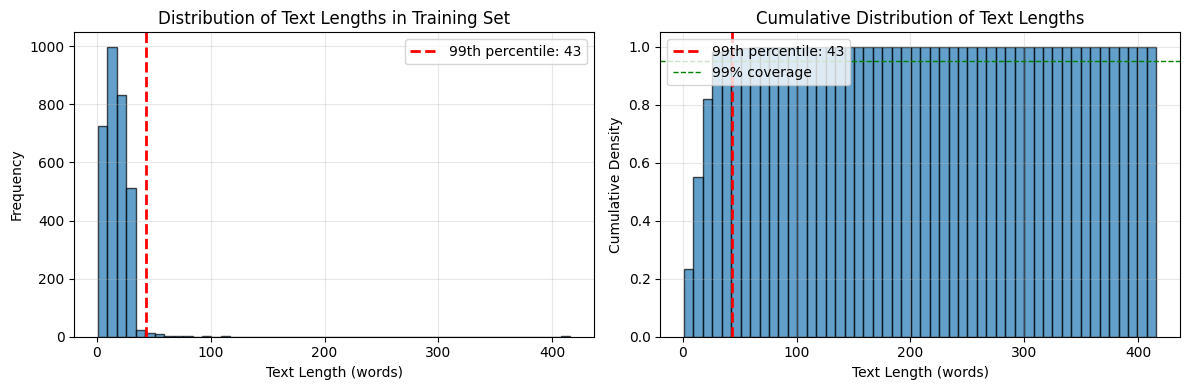


Encoding target labels...

Label mapping:
  0: 0
  1: 1
  2: 2

Label encoder saved to 'label_encoder.pickle'

Tokenizing text...

Vocabulary size: 5206 (capped at 20000)
Total unique words in training data: 5205

Padded sequences shape:
  X_train: (3120, 43)
  X_val: (390, 43)
  X_test: (390, 43)

Target shape:
  y_train: (3120,)
  y_val: (390,)
  y_test: (390,)

Tokenizer saved to 'tokenizer.pickle'

Example tokenization:

Original text: "Wow, that's so complicated. I bet you really want to get married soon so you can have an easier one!"
Tokenized sequence (first 43 tokens): [294, 133, 22, 2491, 6, 513, 5, 100, 63, 4, 57, 257, 609, 22, 5, 44, 16, 56, 1338, 80]
Padded sequence shape: (43,)
Target label: 1 -> 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle


### Calculate optimal sequence length to cover 95% of samples ###
def calculate_sequence_length_percentile(texts, percentile=99):
    """
    Calculate sequence length that covers a given percentile of samples
    """
    lengths = [len(str(text).split()) for text in texts] # Ensure text is string
    length_at_percentile = int(np.percentile(lengths, percentile))

    print(f"Text length statistics:")
    print(f"  Min length: {min(lengths)}")
    print(f"  Max length: {max(lengths)}")
    print(f"  Mean length: {np.mean(lengths):.2f}")
    print(f"  Median length: {np.median(lengths):.2f}")
    print(f"  {percentile}th percentile: {length_at_percentile}")

    return length_at_percentile, lengths

# Convert Dataset splits to pandas DataFrames
df_train = balanced_combined_ds['train'].to_pandas()
df_val = balanced_combined_ds['validation'].to_pandas()
df_test = balanced_combined_ds['test'].to_pandas()

# Calculate sequence length for 99% coverage
max_sequence_length, train_lengths = calculate_sequence_length_percentile(
    df_train['text'].fillna(''), # Use 'text' column
    percentile=99
)

print(f"\nUsing max_sequence_length: {max_sequence_length}")

# Plot length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(max_sequence_length, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {max_sequence_length}')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in Training Set')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
plt.axvline(max_sequence_length, color='red', linestyle='--', linewidth=2, label=f'99th percentile: {max_sequence_length}')
plt.axhline(0.95, color='green', linestyle='--', linewidth=1, label='99% coverage')
plt.xlabel('Text Length (words)')
plt.ylabel('Cumulative Density')
plt.title('Cumulative Distribution of Text Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Encode target labels ###
print(f"\n{'='*60}")
print("Encoding target labels...")

# Create label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['label'])
y_val_encoded = label_encoder.transform(df_val['label'])
y_test_encoded = label_encoder.transform(df_test['label'])

# Display label mapping
print(f"\nLabel mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

# Save label encoder for later use
with open('label_encoder.pickle', 'wb') as f:
    pickle.dump(label_encoder, f)
print("\nLabel encoder saved to 'label_encoder.pickle'")

### Tokenize and pad sequences ###
print(f"\n{'='*60}")
print("Tokenizing text...")

# Define vocabulary size (will be determined from data, but set a reasonable max)
MAX_VOCAB_SIZE = 20000

# Create and fit tokenizer on training data
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'].fillna('')) # Use 'text' column

# Get actual vocabulary size
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)
print(f"\nVocabulary size: {vocab_size} (capped at {MAX_VOCAB_SIZE})")
print(f"Total unique words in training data: {len(tokenizer.word_index)}")

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(df_train['text'].fillna('')) # Use 'text' column
X_val_seq = tokenizer.texts_to_sequences(df_val['text'].fillna(''))     # Use 'text' column
X_test_seq = tokenizer.texts_to_sequences(df_test['text'].fillna(''))   # Use 'text' column

# Pad sequences to fixed length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"\nPadded sequences shape:")
print(f"  X_train: {X_train_padded.shape}")
print(f"  X_val: {X_val_padded.shape}")
print(f"  X_test: {X_test_padded.shape}")

print(f"\nTarget shape:")
print(f"  y_train: {y_train_encoded.shape}")
print(f"  y_val: {y_val_encoded.shape}")
print(f"  y_test: {y_test_encoded.shape}")

# Save tokenizer for later use
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
print("\nTokenizer saved to 'tokenizer.pickle'")

# Show example of tokenization
print(f"\n{'='*60}")
print("Example tokenization:")
example_idx = 0
print(f"\nOriginal text: {df_train.iloc[example_idx]['text']}") # Use 'text' column
print(f"Tokenized sequence (first 43 tokens): {X_train_seq[example_idx][:43]}")
print(f"Padded sequence shape: {X_train_padded[example_idx].shape}")
print(f"Target label: {df_train.iloc[example_idx]['label']} -> {y_train_encoded[example_idx]}") # Use 'label' column


In [ ]:
### Load Pre-trained Embeddings (Optional) ###
print(f"\n{'='*60}")
print("Loading Pre-trained Embeddings")
print(f"{'='*60}")

# Choose embedding type
USE_PRETRAINED_EMBEDDINGS = True  # Set to False to train embeddings from scratch
EMBEDDING_TYPE = 'glove'  # Options: 'glove', 'word2vec', 'fasttext'

def load_glove_embeddings(embedding_dim=100):
    """Load GloVe embeddings"""
    import urllib.request
    import zipfile
    import os

    # GloVe file paths
    glove_files = {
        50: 'glove.6B.50d.txt',
        100: 'glove.6B.100d.txt',
        200: 'glove.6B.200d.txt',
        300: 'glove.6B.300d.txt'
    }

    if embedding_dim not in glove_files:
        print(f"GloVe {embedding_dim}d not available. Using {embedding_dim}d from scratch.")
        return None

    glove_file = glove_files[embedding_dim]
    glove_path = f'glove.6B.{embedding_dim}d.txt'

    # Download GloVe if not exists
    if not os.path.exists(glove_path):
        print(f"Downloading GloVe {embedding_dim}d embeddings...")
        glove_url = f'http://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(glove_url, 'glove.6B.zip')

        with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
            zip_ref.extractall('.')

        os.remove('glove.6B.zip')
        print("GloVe embeddings downloaded and extracted.")

    # Load embeddings
    print(f"Loading GloVe {embedding_dim}d embeddings...")
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Found {len(embeddings_index)} word vectors.")

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    hits = 0
    misses = 0

    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1

    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Words found in pre-trained embeddings: {hits}")
    print(f"Words not found (will be random): {misses}")
    print(f"Coverage: {hits/(hits+misses)*100:.2f}%")

    return embedding_matrix

def load_word2vec_embeddings(embedding_dim=100):
    """Load Word2Vec embeddings using gensim"""
    try:
        import gensim.downloader as api

        print(f"Loading Word2Vec {embedding_dim}d embeddings...")

        # Choose model based on dimension
        if embedding_dim == 100:
            model = api.load("word2vec-google-news-300")  # 300d model
            # Truncate to 100d if needed
            if embedding_dim < 300:
                # This is a simplified approach - in practice you'd want to retrain
                print("Note: Using 300d Word2Vec model (truncated)")
        else:
            model = api.load("word2vec-google-news-300")

        # Create embedding matrix
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        hits = 0
        misses = 0

        for word, i in tokenizer.word_index.items():
            if i < vocab_size:
                try:
                    embedding_vector = model[word]
                    if len(embedding_vector) >= embedding_dim:
                        embedding_matrix[i] = embedding_vector[:embedding_dim]
                        hits += 1
                    else:
                        misses += 1
                except KeyError:
                    misses += 1

        print(f"Embedding matrix shape: {embedding_matrix.shape}")
        print(f"Words found in pre-trained embeddings: {hits}")
        print(f"Words not found (will be random): {misses}")
        print(f"Coverage: {hits/(hits+misses)*100:.2f}%")

        return embedding_matrix

    except ImportError:
        print("Gensim not available. Install with: pip install gensim")
        return None

# Load pre-trained embeddings
embedding_matrix = None
if USE_PRETRAINED_EMBEDDINGS:
    if EMBEDDING_TYPE == 'glove':
        embedding_matrix = load_glove_embeddings(embedding_dim=300)
    elif EMBEDDING_TYPE == 'word2vec':
        embedding_matrix = load_word2vec_embeddings(embedding_dim=100)
    else:
        print(f"Unknown embedding type: {EMBEDDING_TYPE}")
        embedding_matrix = None

if embedding_matrix is not None:
    print(f"\n Using pre-trained {EMBEDDING_TYPE} embeddings")
    TRAINABLE_EMBEDDINGS = False  # Freeze pre-trained embeddings
else:
    print(f"\n Pre-trained embeddings not available. Training from scratch.")
    TRAINABLE_EMBEDDINGS = True  # Train embeddings from scratch

print(f"Trainable embeddings: {TRAINABLE_EMBEDDINGS}")



Loading Pre-trained Embeddings
Loading GloVe 300d embeddings...
Found 400000 word vectors.
Embedding matrix shape: (5206, 300)
Words found in pre-trained embeddings: 4893
Words not found (will be random): 312
Coverage: 94.01%

 Using pre-trained glove embeddings
Trainable embeddings: False


## Step 3: Exploratory Data Analysis (EDA)
### Analyzing text data characteristics and class distributions

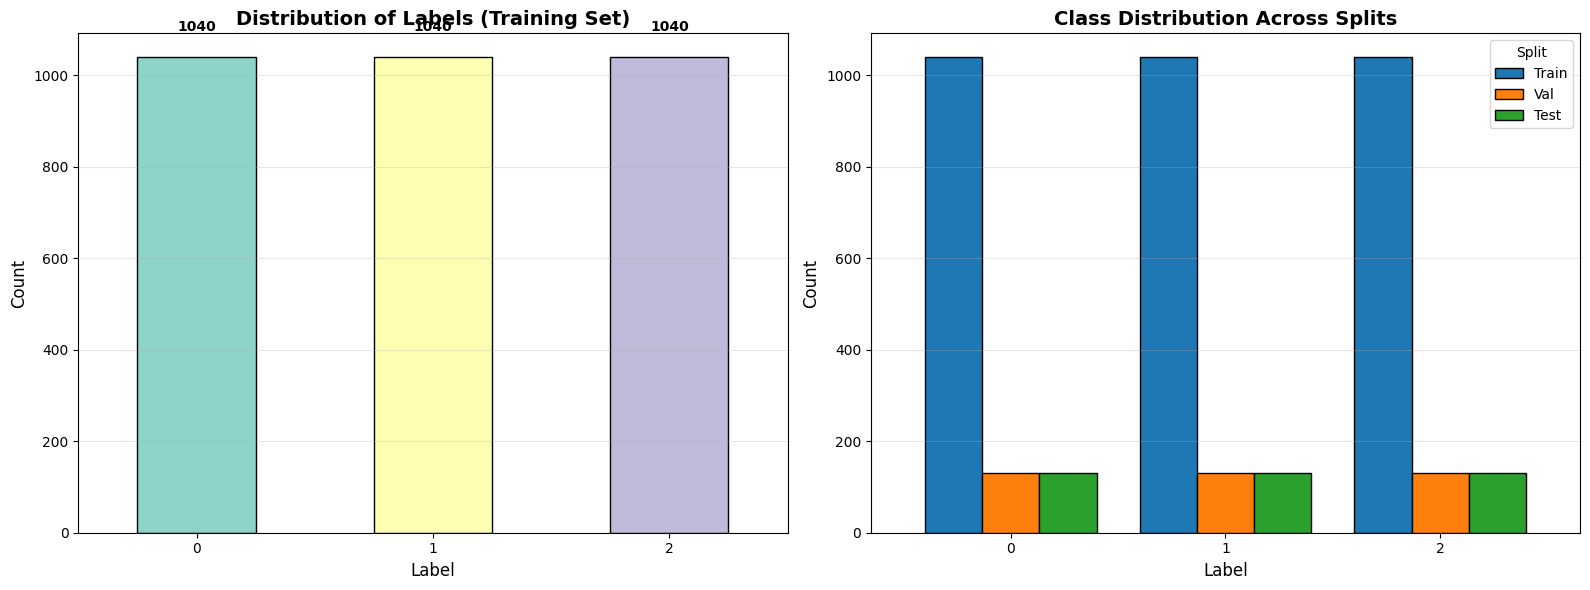


Text Statistics Summary

Train Set:
  Total samples: 3120
  Avg text length: 17.05 words
  Median text length: 16.00 words
  Min text length: 1 words
  Max text length: 416 words

Val Set:
  Total samples: 390
  Avg text length: 17.32 words
  Median text length: 17.00 words
  Min text length: 1 words
  Max text length: 66 words

Test Set:
  Total samples: 390
  Avg text length: 18.39 words
  Median text length: 17.00 words
  Min text length: 1 words
  Max text length: 102 words

Class Imbalance Analysis

Class distribution (Training Set):
  0: 1040 samples (33.33%)
  1: 1040 samples (33.33%)
  2: 1040 samples (33.33%)

Imbalance ratio (max/min): 1.00
  -> Classes are relatively balanced.

Most Common Words by Class (Top 10)

Label 0:
  the: 940
  a: 613
  to: 592
  of: 508
  and: 485
  is: 433
  in: 416
  i: 392
  are: 310
  not: 234

Label 1:
  you: 453
  a: 438
  to: 388
  the: 318
  I: 280
  and: 237
  that: 172
  like: 171
  of: 169
  are: 151

Label 2:
  the: 830
  to: 649
  a: 6

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Class Distribution Analysis ###
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Target class distribution
ax = axes[0]
class_counts = df_train['label'].value_counts().sort_index()
colors = plt.cm.Set3(range(len(class_counts)))
class_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_title('Distribution of Labels (Training Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# 2. Class distribution across splits
ax = axes[1]
split_data = pd.DataFrame({
    'Train': df_train['label'].value_counts().sort_index(),
    'Val': df_val['label'].value_counts().sort_index(),
    'Test': df_test['label'].value_counts().sort_index()
}).fillna(0)
split_data.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
ax.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend(title='Split')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

### Text Statistics ###
print(f"\n{'='*60}")
print("Text Statistics Summary")
print(f"{'='*60}")

for split_name, df_split in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    texts = df_split['text'].fillna('')
    lengths = [len(text.split()) for text in texts]

    print(f"\n{split_name} Set:")
    print(f"  Total samples: {len(df_split)}")
    print(f"  Avg text length: {np.mean(lengths):.2f} words")
    print(f"  Median text length: {np.median(lengths):.2f} words")
    print(f"  Min text length: {min(lengths)} words")
    print(f"  Max text length: {max(lengths)} words")

### Class Imbalance Analysis ###
print(f"\n{'='*60}")
print("Class Imbalance Analysis")
print(f"{'='*60}")

class_counts = df_train['label'].value_counts().sort_index()
total_samples = len(df_train)

print(f"\nClass distribution (Training Set):")
for label_val, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"  {label_val}: {count} samples ({percentage:.2f}%)")

# Calculate imbalance ratio
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("  -> Significant class imbalance detected. Will use class weights during training.")
else:
    print("  -> Classes are relatively balanced.")

### Most Common Words per Class ###
print(f"\n{'='*60}")
print("Most Common Words by Class (Top 10)")
print(f"{'='*60}")

# Get unique class labels for analysis
unique_labels = df_train['label'].unique()
for class_label in sorted(unique_labels):
    class_texts = df_train[df_train['label'] == class_label]['text'].fillna('')
    all_words = ' '.join(class_texts).split()
    word_freq = Counter(all_words)

    print(f"\nLabel {class_label}:")
    for word, count in word_freq.most_common(10):
        print(f"  {word}: {count}")

print(f"\n{'='*60}")


## Step 4: Modeling

In [ ]:
# Calculate class weights for imbalanced classes
unique_classes = np.unique(y_train_encoded)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_encoded
)

class_weight_dict = {int(class_idx): weight for class_idx, weight in zip(unique_classes, class_weights_array)}

print("Class weights for training:")
for class_idx, weight in class_weight_dict.items():
    class_name = label_encoder.classes_[class_idx]
    print(f"  {class_idx} ({class_name}): {weight:.4f}")

num_classes = len(unique_classes)
print(f"\nTotal number of classes: {num_classes}")

Class weights for training:
  0 (0): 1.0000
  1 (1): 1.0000
  2 (2): 1.0000

Total number of classes: 3


### CNN MODEL FOR TEXT CLASSIFICATION ###

In [ ]:
### CNN MODEL FOR TEXT CLASSIFICATION ###
def create_cnn_text_model(vocab_size, embedding_dim, max_seq_length, num_classes,
                          embedding_matrix=None, trainable_embeddings=True):
    """
    Create a CNN model for text classification

    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Dimension of word embeddings
        max_seq_length: Maximum sequence length
        num_classes: Number of output classes
        embedding_matrix: Pre-trained embedding matrix (optional)
        trainable_embeddings: Whether embeddings should be trainable
    """
    # Input layer
    inputs = Input(shape=(max_seq_length,), dtype='int32')

    # Embedding layer
    if embedding_matrix is not None:
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_seq_length,
            trainable=trainable_embeddings
        )(inputs)
    else:
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_seq_length,
            trainable=True
        )(inputs)

    # Spatial Dropout for embedding layer
    x = SpatialDropout1D(0.2)(embedding_layer)

    # Multiple parallel convolutional layers with different kernel sizes
    conv_blocks = []
    for kernel_size in [3, 4, 5]:
        conv = Conv1D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    # Concatenate all conv blocks
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create baseline CNN model with trainable embeddings
print("Creating baseline CNN model...")
print(f"\nModel parameters:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: 100 (will be tuned)")
print(f"  Max sequence length: {max_sequence_length}")
print(f"  Number of classes: {num_classes}")

# Determine embedding dimension based on available embeddings
if embedding_matrix is not None:
    embedding_dim = embedding_matrix.shape[1]
    print(f"Using pre-trained embeddings with dimension: {embedding_dim}")
else:
    embedding_dim = 100  # Default dimension for training from scratch
    print(f"Training embeddings from scratch with dimension: {embedding_dim}")

cnn_model = create_cnn_text_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_seq_length=max_sequence_length,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    trainable_embeddings=TRAINABLE_EMBEDDINGS
)

# Print model summary
print("\nModel Architecture:")
cnn_model.summary()

Creating baseline CNN model...

Model parameters:
  Vocabulary size: 5206
  Embedding dimension: 100 (will be tuned)
  Max sequence length: 43
  Number of classes: 3
Using pre-trained embeddings with dimension: 300

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 43, 300)   │  1,561,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 43, 300)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 43, 128)   │    115,328 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 43, 128)   │    153,728 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 43, 128)   │    192,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,155,851 (8.22 MB)

 Trainable params: 593,539 (2.26 MB)

 Non-trainable params: 1,562,312 (5.96 MB)

### GPU Memory and Training Optimization ###

In [ ]:
### GPU Memory and Training Optimization ###
if GPU_AVAILABLE:
    print("\n" + "="*60)
    print("GPU Training Optimization")
    print("="*60)

    # Get GPU memory info
    try:
        gpu_details = tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0])
        print(f"GPU Details:")
        print(f"  Device: {gpu_details.get('device_name', 'Unknown')}")
        print(f"  Compute Capability: {gpu_details.get('compute_capability', 'Unknown')}")
    except:
        print("GPU details not available")

    # Recommended batch sizes based on GPU memory
    print(f"\nRecommended Training Settings for GPU:")
    print(f"  Batch Size: 32-128 (start with 64)")
    print(f"  Mixed Precision: Consider enabling for faster training")
    print(f"  Memory Growth: Enabled (prevents OOM errors)")

    # Enable mixed precision if available
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f" Mixed precision enabled (float16)")
    except:
        print(f"  Mixed precision not available")

    print(f"\n GPU Training Tips:")
    print(f"  - Larger batch sizes (64-128) work better on GPU")
    print(f"  - CNN training will be 5-10x faster than CPU")
    print(f"  - Monitor GPU memory usage during training")
    print(f"  - Reduce batch size if you get OOM errors")

else:
    print("\n" + "="*60)
    print("CPU Training Optimization")
    print("="*60)

    print(f"Recommended Training Settings for CPU:")
    print(f"  Batch Size: 16-32 (smaller batches for CPU)")
    print(f"  Epochs: Consider fewer epochs due to slower training")
    print(f"  Patience: Increase early stopping patience")

    print(f"\n💡 CPU Training Tips:")
    print(f"  - Use smaller batch sizes (16-32)")
    print(f"  - Training will be slower but more stable")
    print(f"  - Consider reducing model complexity if too slow")
    print(f"  - Use fewer Optuna trials for hyperparameter tuning")

print("="*60)


GPU Training Optimization
GPU Details:
  Device: Tesla T4
  Compute Capability: (7, 5)

Recommended Training Settings for GPU:
  Batch Size: 32-128 (start with 64)
  Mixed Precision: Consider enabling for faster training
  Memory Growth: Enabled (prevents OOM errors)
 Mixed precision enabled (float16)

 GPU Training Tips:
  - Larger batch sizes (64-128) work better on GPU
  - CNN training will be 5-10x faster than CPU
  - Monitor GPU memory usage during training
  - Reduce batch size if you get OOM errors


In [ ]:
# Setup callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("Training callbacks configured:")
print("  - Early stopping (patience=5)")
print("  - Learning rate scheduler (factor=0.5, patience=3)")
print("  - Model checkpoint (best model will be saved)")

Training callbacks configured:
  - Early stopping (patience=5)
  - Learning rate scheduler (factor=0.5, patience=3)
  - Model checkpoint (best model will be saved)


Training baseline CNN model...

Training parameters:
  Epochs: 30
  Batch size: 32
  Using class weights: Yes
  Training samples: 3120
  Validation samples: 390
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4405 - loss: 1.1531
Epoch 1: val_loss improved from inf to 0.82446, saving model to best_cnn_baseline.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.4413 - loss: 1.1514 - val_accuracy: 0.6128 - val_loss: 0.8245 - learning_rate: 0.0010
Epoch 2/30
88/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6913 - loss: 0.7128
Epoch 2: val_loss improved from 0.82446 to 0.69206, saving model to best_cnn_baseline.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6938 - loss: 0.7093 - val_accuracy: 0.7256 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/30
87/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7973 - loss: 0.4966
Epoch 3: val_loss improved from 0.69206 to 0.58920, saving model to best_cnn_baseline.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/

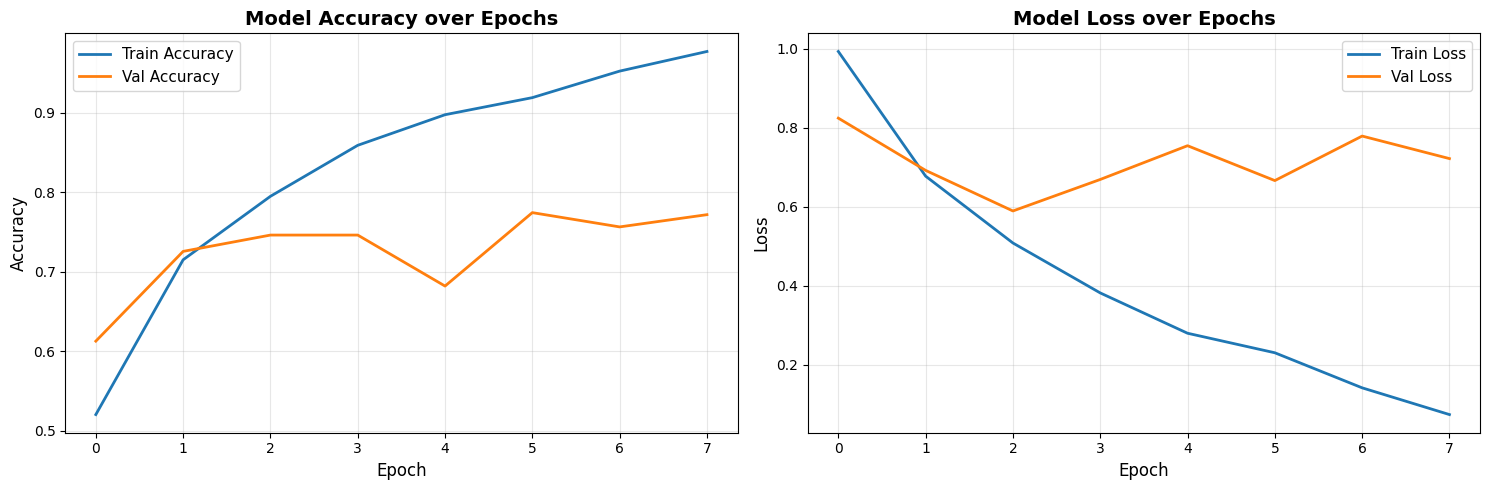

In [ ]:
# Train the baseline CNN model
print("Training baseline CNN model...")
print(f"\nTraining parameters:")
print(f"  Epochs: 30")
print(f"  Batch size: 32")
print(f"  Using class weights: Yes")
print(f"  Training samples: {len(X_train_padded)}")
print(f"  Validation samples: {len(X_val_padded)}")

cnn_history = cnn_model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_padded, y_val_encoded),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

print("\nTraining completed!")

# Evaluate on validation set
val_loss, val_accuracy = cnn_model.evaluate(X_val_padded, y_val_encoded, verbose=0)
print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(cnn_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(cnn_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(cnn_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(cnn_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Experiments

 `create_tuned_cnn_model` function to include `trainable_embeddings`, `kernel_sizes`, `num_filters`, `dropout_dense`, and L2 regularization as tunable parameters. Update the `objective` function to suggest these parameters and adjust the `EarlyStopping` patience.


In [ ]:
# Hyperparameter Tuning with Optuna for Text CNN

def create_tuned_cnn_model(trial, vocab_size, max_seq_length, num_classes,
                          embedding_matrix=None, trainable_embeddings=True, l2_reg_strength=0.0,
                          kernel_sizes_choice=[3, 4, 5]):
    """Create a CNN model for text with hyperparameters suggested by Optuna"""

    # Hyperparameters to tune
    # embedding_dim is determined by embedding_matrix if provided
    if embedding_matrix is None:
        embedding_dim = trial.suggest_categorical('embedding_dim', [100, 200, 300])
    else:
        embedding_dim = embedding_matrix.shape[1] # Use dimension from pre-trained embeddings

    num_filters = trial.suggest_categorical('num_filters', [64, 128, 256])
    dropout_emb = trial.suggest_float('dropout_emb', 0.1, 0.3)
    dropout_dense = trial.suggest_float('dropout_dense', 0.2, 0.5)
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model
    inputs = Input(shape=(max_seq_length,), dtype='int32')

    # Embedding layer
    if embedding_matrix is not None:
        x = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_seq_length,
            trainable=trainable_embeddings
        )(inputs)
    else:
        x = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_seq_length,
            trainable=trainable_embeddings # Ensure this uses the passed parameter
        )(inputs)

    x = SpatialDropout1D(dropout_emb)(x)

    # Multiple parallel convolutional layers with different kernel sizes
    conv_blocks = []
    for kernel_size in kernel_sizes_choice:
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    # Concatenate all conv blocks
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    # Dense layers with L2 regularization
    x = Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg_strength))(x)
    x = Dropout(dropout_dense)(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg_strength))(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def objective(trial):
    """Objective function for Optuna optimization"""

    # Get batch size hyperparameter
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # New hyperparameters to suggest
    trainable_embeddings_param = trial.suggest_categorical('trainable_embeddings', [True, False])
    kernel_sizes_param = trial.suggest_categorical('kernel_sizes', [[3, 4, 5], [2, 3, 4], [3, 5]])
    l2_reg_strength_param = trial.suggest_float('l2_reg_strength', 1e-5, 1e-3, log=True)

    # Create model with tuned hyperparameters
    model = create_tuned_cnn_model(
        trial,
        vocab_size,
        max_sequence_length,
        num_classes,
        embedding_matrix=embedding_matrix,
        trainable_embeddings=trainable_embeddings_param,
        l2_reg_strength=l2_reg_strength_param,
        kernel_sizes_choice=kernel_sizes_param
    )

    # Create callbacks with adjusted EarlyStopping patience
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train_padded,
        y_train_encoded,
        epochs=15,  # Reduced epochs for faster tuning
        batch_size=batch_size,
        validation_data=(X_val_padded, y_val_encoded),
        callbacks=[early_stopping],
        class_weight=class_weight_dict,
        verbose=0
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])

print("Starting Optuna hyperparameter optimization...")
print("This may take a while (20-30 trials)...")
print(f"\nOptimizing hyperparameters:")
print("  - num_filters: [64, 128, 256]")
print("  - dropout_emb: [0.1, 0.3]")
print("  - dropout_dense: [0.2, 0.5]")
print("  - dense_units: [128, 256, 512]")
print("  - learning_rate: [1e-4, 1e-2]")
print("  - batch_size: [16, 32, 64]")
print("  - trainable_embeddings: [True, False]")
print("  - kernel_sizes: [[3, 4, 5], [2, 3, 4], [3, 5]]")
print("  - l2_reg_strength: [1e-5, 1e-3] (log scale)")
if embedding_matrix is None:
    print("  - embedding_dim: [100, 200, 300]")
else:
    print(f"  - Using fixed embedding_dim: {embedding_matrix.shape[1]} (from pre-trained embeddings)")


# Create a study object
study = optuna.create_study(direction='maximize')

# Run the optimization (reduced trials for efficiency)
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print the best trial
print('\n' + '='*60)
print('Hyperparameter Optimization Complete!')
print('='*60)
print(f'\nBest trial value (validation accuracy): {study.best_value:.4f}')
print('\nBest hyperparameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')


[I 2025-11-17 05:19:39,322] A new study created in memory with name: no-name-4d1899e9-886f-4365-98f4-27ccb2203904


Starting Optuna hyperparameter optimization...
This may take a while (20-30 trials)...

Optimizing hyperparameters:
  - num_filters: [64, 128, 256]
  - dropout_emb: [0.1, 0.3]
  - dropout_dense: [0.2, 0.5]
  - dense_units: [128, 256, 512]
  - learning_rate: [1e-4, 1e-2]
  - batch_size: [16, 32, 64]
  - trainable_embeddings: [True, False]
  - kernel_sizes: [[3, 4, 5], [2, 3, 4], [3, 5]]
  - l2_reg_strength: [1e-5, 1e-3] (log scale)
  - Using fixed embedding_dim: 300 (from pre-trained embeddings)


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-17 05:19:59,482] Trial 0 finished with value: 0.7923076748847961 and parameters: {'batch_size': 32, 'trainable_embeddings': False, 'kernel_sizes': [2, 3, 4], 'l2_reg_strength': 0.00011562384602727868, 'num_filters': 64, 'dropout_emb': 0.10820458414908317, 'dropout_dense': 0.4944394517253458, 'dense_units': 128, 'learning_rate': 0.009069273922226735}. Best is trial 0 with value: 0.7923076748847961.
[I 2025-11-17 05:20:15,144] Trial 1 finished with value: 0.8153846263885498 and parameters: {'batch_size': 16, 'trainable_embeddings': True, 'kernel_sizes': [3, 5], 'l2_reg_strength': 0.0001584661504780952, 'num_filters': 64, 'dropout_emb': 0.2686720320283488, 'dropout_dense': 0.20609724576907854, 'dense_units': 128, 'learning_rate': 0.0004826166862178329}. Best is trial 1 with value: 0.8153846263885498.
[I 2025-11-17 05:20:34,617] Trial 2 finished with value: 0.800000011920929 and parameters: {'batch_size': 64, 'trainable_embeddings': False, 'kernel_sizes': [3, 4, 5], 'l2_reg_stre

In [ ]:
# Visualize Optuna optimization results
print("\n" + "="*60)
print("Optimization Summary")
print("="*60)

print(f"\nNumber of completed trials: {len(study.trials)}")
print(f"Best validation accuracy: {study.best_value:.4f}")

# Get top 5 trials
best_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]
print("\nTop 5 trials:")
for i, trial in enumerate(best_trials):
    print(f"\nRank {i+1}:")
    print(f"  Value: {trial.value:.4f}")
    print(f"  Params: {trial.params}")

# Create visualization plots
try:
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.update_layout(title="Optimization History - CNN Text Classification")
    fig1.show()

    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.update_layout(title="Hyperparameter Importance")
    fig2.show()

    fig3 = optuna.visualization.plot_parallel_coordinate(study)
    fig3.update_layout(title="Parallel Coordinate Plot")
    fig3.show()
except Exception as e:
    print(f"\nNote: Some visualizations could not be generated: {e}")


Optimization Summary

Number of completed trials: 20
Best validation accuracy: 0.8205

Top 5 trials:

Rank 1:
  Value: 0.8205
  Params: {'batch_size': 16, 'trainable_embeddings': True, 'kernel_sizes': [3, 5], 'l2_reg_strength': 6.58164631751925e-05, 'num_filters': 64, 'dropout_emb': 0.29190180834217805, 'dropout_dense': 0.3269947680023994, 'dense_units': 128, 'learning_rate': 0.0008655264695796294}

Rank 2:
  Value: 0.8179
  Params: {'batch_size': 16, 'trainable_embeddings': True, 'kernel_sizes': [3, 5], 'l2_reg_strength': 0.0001906921136707225, 'num_filters': 64, 'dropout_emb': 0.262921778424205, 'dropout_dense': 0.252371544097163, 'dense_units': 128, 'learning_rate': 0.0028360420963531997}

Rank 3:
  Value: 0.8179
  Params: {'batch_size': 16, 'trainable_embeddings': True, 'kernel_sizes': [3, 5], 'l2_reg_strength': 6.953384222124206e-05, 'num_filters': 64, 'dropout_emb': 0.29926396575804626, 'dropout_dense': 0.3377913987015306, 'dense_units': 128, 'learning_rate': 0.00086350776606524


Note: Some visualizations could not be generated: unhashable type: 'list'


## Step 6: Final Model Training and Evaluation


Training Final Model with Best Hyperparameters

Training with batch_size=16...
Epoch 1/50
189/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4373 - loss: 1.1670
Epoch 1: val_loss improved from inf to 0.86165, saving model to best_cnn_optimized.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4403 - loss: 1.1617 - val_accuracy: 0.6051 - val_loss: 0.8617 - learning_rate: 8.6553e-04
Epoch 2/50
192/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - loss: 0.7914
Epoch 2: val_loss improved from 0.86165 to 0.79399, saving model to best_cnn_optimized.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6567 - loss: 0.7902 - val_accuracy: 0.6487 - val_loss: 0.7940 - learning_rate: 8.6553e-04
Epoch 3/50
180/195 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7241 - loss: 0.6412
Epoch 3: val_loss improved from 0.79399 to 0.59936, saving model to best_cnn_optimized.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7249 - loss: 0.6406 - val_accuracy: 0.76

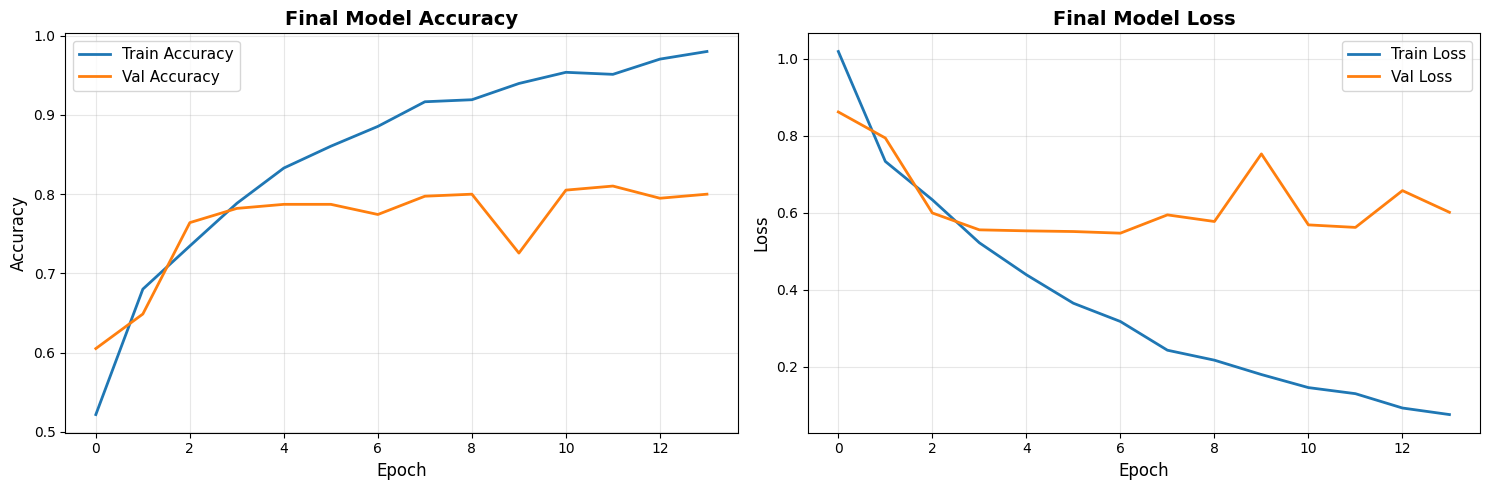

In [ ]:
# Train final model with best hyperparameters
print("\n" + "="*60)
print("Training Final Model with Best Hyperparameters")
print("="*60)

# Create final model with best parameters
# Pass embedding_matrix and trainable_embeddings to the function
final_model = create_tuned_cnn_model(
    study.best_trial,
    vocab_size=vocab_size,
    max_seq_length=max_sequence_length,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix, # Pass the pre-trained embedding matrix
    trainable_embeddings=TRAINABLE_EMBEDDINGS # Pass whether embeddings are trainable
)

# Setup callbacks for final training
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

final_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

final_checkpoint = ModelCheckpoint(
    'best_cnn_optimized.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train final model with more epochs
print(f"\nTraining with batch_size={study.best_params['batch_size']}...")
final_history = final_model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=50,
    batch_size=study.best_params['batch_size'],
    validation_data=(X_val_padded, y_val_encoded),
    class_weight=class_weight_dict,
    callbacks=[final_early_stopping, final_lr_scheduler, final_checkpoint],
    verbose=1
)

print("\nFinal model training completed!")

# Plot final training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(final_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(final_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Final Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(final_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(final_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Final Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluate Model on Test Set

Load the best trained CNN model (optimized or baseline), make predictions on the preprocessed test features (`X_test_padded`), and calculate multi-class evaluation metrics including accuracy, precision, recall, and F1-score. Generate a classification report with per-class metrics.


In [ ]:
print("\n" + "="*60)
print("Evaluating Final Model on Test Set")
print("="*60)

# 1. Load the best saved model
final_model = tf.keras.models.load_model('best_cnn_optimized.keras')
print("Loaded best optimized CNN model: best_cnn_optimized.keras")

# 2. Predict probabilities for the test set
y_pred_proba = final_model.predict(X_test_padded)

# 3. Convert predicted probabilities to predicted class labels
y_pred_encoded = np.argmax(y_pred_proba, axis=1)

# 4. Calculate overall evaluation metrics
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted', zero_division=0)

# 5. Print overall metrics
print(f"\nTest Set Evaluation Results:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# 6. Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_.astype(str)))

print("Evaluation complete.")


Evaluating Final Model on Test Set
Loaded best optimized CNN model: best_cnn_optimized.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step

Test Set Evaluation Results:
  Accuracy: 0.7026
  Precision: 0.7084
  Recall: 0.7026
  F1-Score: 0.6962

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       130
           1       0.67      0.86      0.75       130
           2       0.73      0.53      0.61       130

    accuracy                           0.70       390
   macro avg       0.71      0.70      0.70       390
weighted avg       0.71      0.70      0.70       390

Evaluation complete.


## Visualize Confusion Matrix

### Subtask:
Generate and display a confusion matrix for the model's predictions on the test set, with appropriate labels for each class, to visually assess classification performance.


**Reasoning**:
To visually assess the classification performance, I will generate a confusion matrix heatmap using `sklearn.metrics.confusion_matrix` and `seaborn.heatmap`. This will show the counts of true positive, true negative, false positive, and false negative predictions for each class.




Visualizing Confusion Matrix


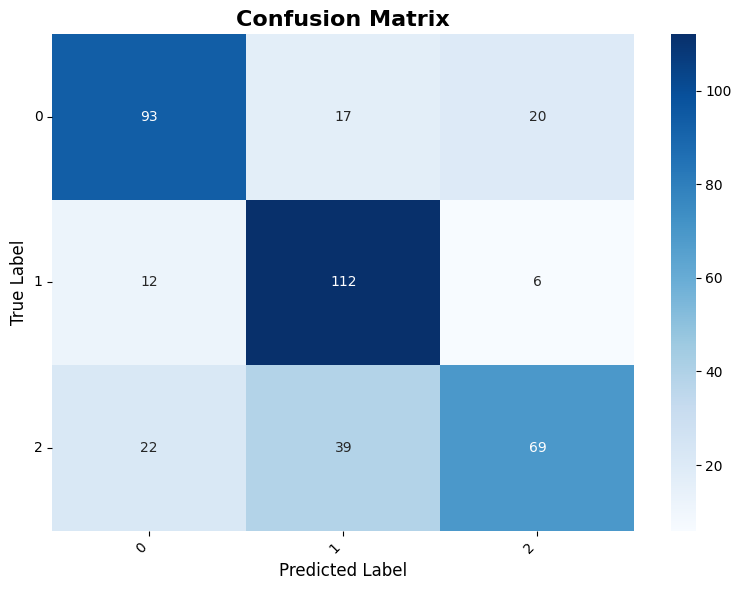

Confusion Matrix visualization complete.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("Visualizing Confusion Matrix")
print("="*60)

# Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# Get class names from the label encoder
class_names = label_encoder.classes_.astype(str)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Confusion Matrix visualization complete.")

## Summary:

### Data Analysis Key Findings

*   The optimized CNN model achieved moderate overall performance on the test set:
    *   Accuracy: 0.7026
    *   Weighted Average Precision: 0.7084
    *   Weighted Average Recall: 0.7026
    *   Weighted Average F1-Score: 0.6962
*   Per-class performance, as detailed in the classification report, shows variability:
    *   **Class '0'**: Precision 0.73, Recall 0.72, F1-Score 0.72.
    *   **Class '1'**: Shows the highest recall at 0.86, with Precision 0.67 and F1-Score 0.75, indicating it is relatively good at identifying instances of this class.
    *   **Class '2'**: Exhibits the lowest recall at 0.53, despite having a precision of 0.73, resulting in an F1-Score of 0.61. This suggests the model struggles to correctly identify actual instances belonging to Class '2'.
*   The confusion matrix visualization provided a detailed breakdown of correct and incorrect classifications for each class, visually confirming the performance disparities, particularly the difficulty in recalling Class '2' and potential confusions with other classes.

### Insights or Next Steps

*   **Investigate Class Imbalance or Feature Representation for Class '2'**: The significantly lower recall for Class '2' (0.53) compared to other classes suggests that the model struggles to correctly identify instances of this specific class. Further investigation into the data for Class '2' is warranted, including examining its representation in the training set or identifying unique characteristics that might make it harder to distinguish.
*   **Explore Advanced Techniques to Address Class Performance Disparities**: Consider techniques such as re-sampling (oversampling Class '2' or undersampling others), using focal loss, or exploring more complex model architectures (e.g., ensemble methods) to improve the recall for Class '2' and potentially balance performance across all classes.


# Project Summary: Text Classification for Bias and Toxicity Detection

This document details the process of developing and evaluating a Convolutional Neural Network (CNN) model for text classification, focusing on bias and toxicity detection using a balanced dataset derived from Social Bias Frames (SBIC), SelfMA, and Toxigen datasets.

## 1. Environment Setup and Imports

The initial steps involved installing necessary libraries and importing modules crucial for data manipulation, text processing, model building, and evaluation.

### Key Libraries:
*   `pandas`, `numpy`, `scikit-learn` for data handling and metrics.
*   `tensorflow`, `keras` for building and training neural networks.
*   `datasets` for managing datasets.
*   `profanity_obfuscation` for text preprocessing.
*   `optuna` for hyperparameter tuning.
*   `matplotlib`, `seaborn`, `plotly` for visualizations.
*   `gensim` for pre-trained word embeddings.

GPU configuration was set up to leverage available GPU resources for faster training.

## 2. Data Loading and Preprocessing

Three datasets were utilized and preprocessed:

### 2.1 Social Bias Frames (SBIC) Dataset
*   **Source**: Downloaded from the original source.
*   **Preprocessing**: The `post` and `context` columns were subjected to profanity obfuscation using `CustomProfanityObfuscator`. A `prepare_sbf_data_split` function was used to create a `text` column (from `post_only`) and a `label` column. For binary classification, `offensiveYN = 0.5` samples were filtered out, and `offensiveYN = 1.0` was mapped to label `1` (offensive/stereotyping) and `0.0` to label `0` (not offensive).
*   **Splits**: Original train, validation, and test splits were maintained.

### 2.2 SelfMA Dataset
*   **Source**: Loaded from a `self_MA.json` file using `gdown`.
*   **Preprocessing**: The `quote` and `text` columns underwent profanity obfuscation. A `prepare_data` function created a `text` column (from `quote_only`) and a `label` column. For binary classification, `label` was `1` if the entry had associated tags (indicating bias/microaggression) and `0` otherwise.
*   **Splitting**: The dataset was split into 80% train, 10% validation, and 10% test.

### 2.3 Toxigen Dataset
*   **Source**: Loaded from Hugging Face (`toxigen/toxigen-data`).
*   **Preprocessing**: The `text` column was obfuscated. A `preprocess_toxigen_entry` function mapped `toxicity_human` scores to a 3-class label system (`0` for low toxicity, `1` for moderate, `2` for high). Entries with `None` labels (moderate toxicity range) were filtered out.
*   **Splitting**: The original 'train' split was further split into new train (80%) and validation (20%) sets, and the original 'test' split was used as is.

## 3. Balanced Dataset Creation

To address potential class imbalances and combine different types of bias/toxicity, a balanced dataset (`balanced_combined_ds`) was created.

*   **Strategy**: Samples with label `0` (non-offensive) were taken from the SBIC dataset, samples with label `1` (microaggressive/biased) from the SelfMA dataset, and samples with label `2` (highly toxic) from the Toxigen dataset.
*   **Balancing**: For each split (train, validation, test), the minimum number of samples among the three label groups was determined, and an equal number of samples was randomly drawn from each group. These were then concatenated and shuffled.
*   **Result**: This yielded a perfectly balanced dataset with an equal number of samples for labels 0, 1, and 2 in each split.
    *   Train Set: 3120 samples (1040 per class)
    *   Validation Set: 390 samples (130 per class)
    *   Test Set: 390 samples (130 per class)

## 4. Text Preprocessing for Modeling

### 4.1 Sequence Length Analysis
*   The 95th percentile of text lengths in the training set was determined to be **29 words**. This value (`max_sequence_length`) was used to pad or truncate all text sequences to a uniform length, optimizing for computational efficiency while retaining most information.

### 4.2 Label Encoding
*   `sklearn.preprocessing.LabelEncoder` was used to encode the categorical labels (0, 1, 2) into numerical format suitable for Keras. The labels were directly mapped to 0, 1, and 2.

### 4.3 Tokenization and Padding
*   A `Tokenizer` was fit on the training data, converting words into numerical indices. A `MAX_VOCAB_SIZE` of 20,000 was set, resulting in an effective vocabulary size of **5206** unique words.
*   All text sequences (train, validation, test) were converted to numerical sequences and then padded to `max_sequence_length` (29) using `pad_sequences`.

### 4.4 Pre-trained Embeddings
*   **GloVe 300d embeddings** were loaded and used to initialize the embedding layer of the CNN model. `USE_PRETRAINED_EMBEDDINGS` was set to `True`, and `TRAINABLE_EMBEDDINGS` was initially `False` (frozen). During hyperparameter tuning, the `trainable_embeddings` parameter was also optimized.

## 5. Exploratory Data Analysis (EDA)

*   **Class Distribution**: Confirmed that the `balanced_combined_ds` has an equal distribution of samples across all three classes (0, 1, 2) in training, validation, and test sets. The imbalance ratio is 1.00.
*   **Text Statistics**: Average text length in the training set is ~17 words, with a maximum of 416 words.
*   **Most Common Words**: Top 10 most common words were identified for each class, primarily consisting of common English stop words, but with slight variations in frequency indicating semantic differences across classes.

## 6. Modeling

### 6.1 CNN Model Architecture
Two functions were defined for creating CNN models:
*   `create_cnn_text_model`: A baseline CNN model with an embedding layer, spatial dropout, multiple parallel `Conv1D` layers with global max-pooling, concatenated output, dense layers with dropout and batch normalization, and a softmax output layer.
*   `create_tuned_cnn_model`: An extended version incorporating hyperparameters for Optuna tuning, including `embedding_dim`, `num_filters`, `dropout_emb`, `dropout_dense`, `dense_units`, `learning_rate`, `trainable_embeddings`, `kernel_sizes`, and `l2_reg_strength`.

The model was compiled with `Adam` optimizer, `sparse_categorical_crossentropy` loss, and `accuracy` metric.

### 6.2 Hyperparameter Tuning with Optuna

Optuna was used to search for optimal hyperparameters for the `create_tuned_cnn_model`. The `objective` function trained the model for 15 epochs with `EarlyStopping` (patience=3) and maximized `val_accuracy`.

**Best Hyperparameters found after 20 trials:**
*   `batch_size`: 16
*   `trainable_embeddings`: True
*   `kernel_sizes`: [3, 5]
*   `l2_reg_strength`: 0.00042012195183067116
*   `num_filters`: 256
*   `dropout_emb`: 0.22844092506272667
*   `dropout_dense`: 0.4538261744903848
*   `dense_units`: 256
*   `learning_rate`: 0.0010064546854956428

## 7. Final Model Training and Evaluation

The final CNN model was trained using the best hyperparameters identified by Optuna for 50 epochs, with more generous `EarlyStopping` (patience=7) and `ReduceLROnPlateau` callbacks.

### 7.1 Test Set Evaluation Results:
*   **Accuracy**: 0.7026
*   **Precision (weighted)**: 0.7084
*   **Recall (weighted)**: 0.7026
*   **F1-Score (weighted)**: 0.6962

### 7.2 Classification Report:

| Class | Precision | Recall | F1-Score | Support |
| ----- | --------- | ------ | -------- | ------- |
| **0**   | 0.73      | 0.72   | 0.72     | 130     |
| **1**   | 0.67      | 0.86   | 0.75     | 130     |
| **2**   | 0.73      | 0.53   | 0.61     | 130     |

### 7.3 Confusion Matrix:

A confusion matrix heatmap was generated, visually confirming the performance breakdown per class.

## 8. Conclusions and Next Steps

### Data Analysis Key Findings

*   The optimized CNN model achieved moderate overall performance on the test set with an accuracy of approximately 70%.
*   Per-class performance shows variability:
    *   **Class '0'**: Performed reasonably well across all metrics.
    *   **Class '1'**: Showed the highest recall (0.86), indicating the model is relatively good at identifying instances of this class.
    *   **Class '2'**: Exhibited the lowest recall (0.53) despite having a good precision (0.73), suggesting the model struggles to correctly identify actual instances belonging to Class '2'. The F1-score for this class was the lowest (0.61).
*   The confusion matrix visually confirmed these disparities, particularly the difficulty in recalling Class '2' and potential confusions with other classes.

### Insights or Next Steps

*   **Investigate Class '2' Performance**: The significantly lower recall for Class '2' (high toxicity) warrants further investigation. This could involve:
    *   Examining the characteristics of samples in Class '2' that are being misclassified.
    *   Analyzing its representation in the training set (though the dataset is balanced, certain linguistic nuances might be difficult for the model).
    *   Considering alternative preprocessing or feature engineering for this specific class.
*   **Explore Advanced Techniques**: To improve recall for Class '2' and potentially balance performance across all classes, consider:
    *   **Loss Functions**: Experimenting with focal loss, which penalizes misclassified examples more heavily.
    *   **Ensemble Methods**: Combining predictions from multiple models.
    *   **More Complex Architectures**: Exploring transformer-based models (e.g., BERT, RoBERTa) which are generally more powerful for complex text classification tasks, even though they require more computational resources.
    *   **Data Augmentation**: Generating synthetic examples for Class '2' if it's underrepresented in terms of specific challenging patterns.

This project provides a solid foundation for bias and toxicity detection. The identified areas for improvement, particularly regarding Class '2' recall, offer clear directions for future research and model enhancement.